Import Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Input

Download and Prepare Stock Data

In [ ]:
# Download stock data
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data


In [ ]:
# Example usage
stock_ticker = 'AAPL'  # Apple stock ticker
start = '2023-01-01'
end = '2025-10-01'

# Download data
data = download_stock_data(stock_ticker, start, end)

# Display first few rows of the data
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-01-03,123.632538,129.395526,122.742880,128.782657,112117500
2023-01-04,124.907707,127.181276,123.642420,125.431615,89113600
2023-01-05,123.583099,126.301493,123.326093,125.668849,80962700
2023-01-06,128.130219,128.792516,123.454587,124.561717,87754700
2023-01-09,128.654144,131.876686,128.397138,128.970474,70790800


In [ ]:
# Handle missing data: Interpolation
data.interpolate(method='linear', inplace=True)
# Fill missing values using forward filling
data.fillna(method='ffill', inplace=True)

# Or use interpolation
data.interpolate(method='linear', inplace=True)
# Drop rows with any missing values
data.dropna(inplace=True)

# Check for missing values
print(data.isnull().sum())

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


<ipython-input-66-eca75c82b430>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


# Normalization/Standardization
Scale data to a uniform range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize 'Close' price between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])


Feature Creation
Generate new features like moving averages.

In [ ]:
# Create Moving Averages
data['SMA_30'] = data['Close'].rolling(window=30).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

# Momentum Indicator (Rate of Change)
data['Momentum'] = data['Close'].diff(4)  # 4-day momentum


Date-Time Handling
Convert date features and create lag features.

In [ ]:
# Reset index to create a 'Date' column
data.reset_index(inplace=True)

# Create lag features
data['Lag_1'] = data['Close'].shift(1)
data['Lag_7'] = data['Close'].shift(7)

# Extract day of the week and month
data['Day_of_Week'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month

# Drop NaN values generated by lagging and rolling
data.dropna(inplace=True)


## Exploratory Data Analysis (EDA)
2.1 Visualize Time Series
Plot historical prices and technical indicators.

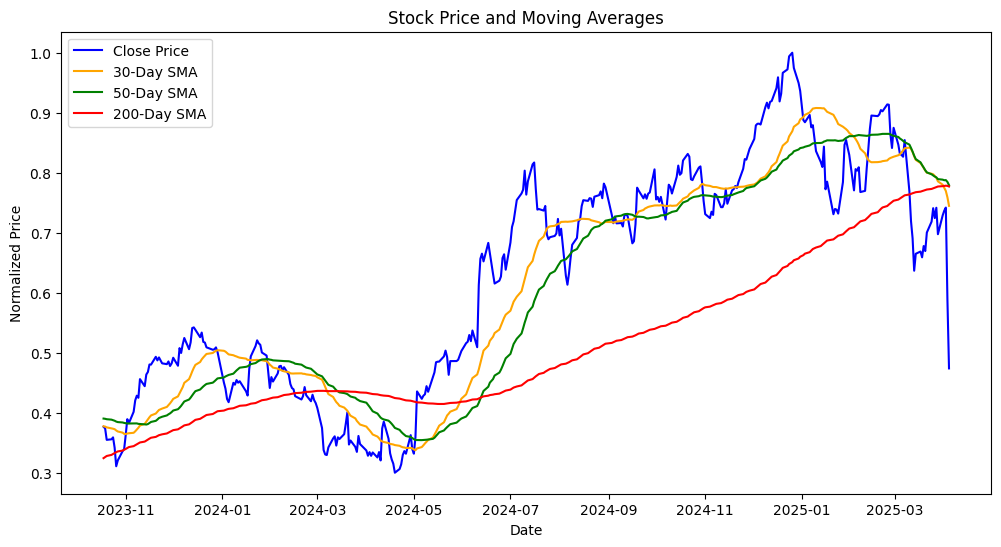

In [ ]:
import matplotlib.pyplot as plt

# Plot closing price and moving averages
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.plot(data['Date'], data['SMA_30'], label='30-Day SMA', color='orange')
plt.plot(data['Date'], data['SMA_50'], label='50-Day SMA', color='green')
plt.plot(data['Date'], data['SMA_200'], label='200-Day SMA', color='red')
plt.title('Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()


 ## Correlation Analysis
Identify relationships between stock prices and indicators.

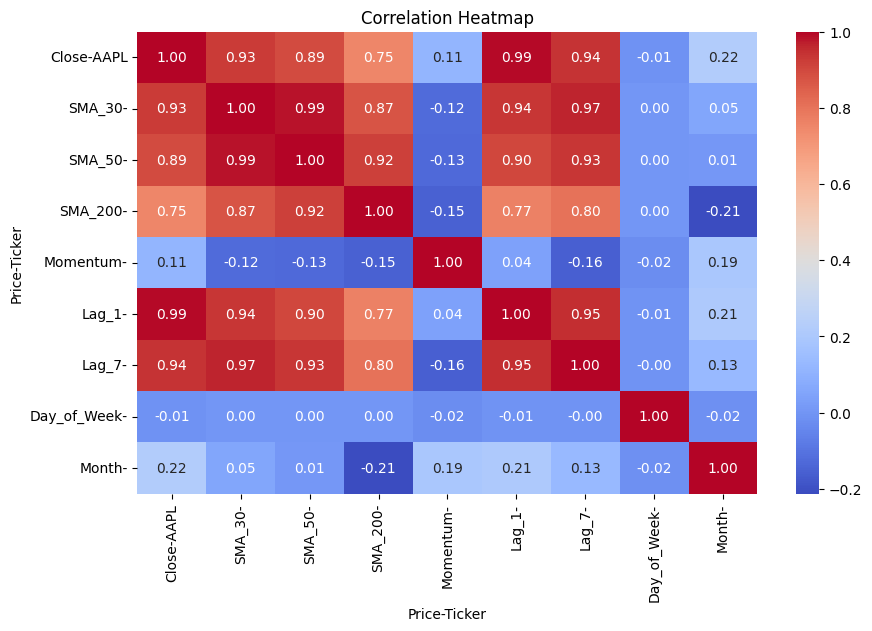

In [ ]:
import seaborn as sns

# Calculate correlations
correlation_matrix = data[['Close', 'SMA_30', 'SMA_50', 'SMA_200', 'Momentum', 'Lag_1', 'Lag_7', 'Day_of_Week', 'Month']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


Distribution Analysis
Check the distribution of stock returns.

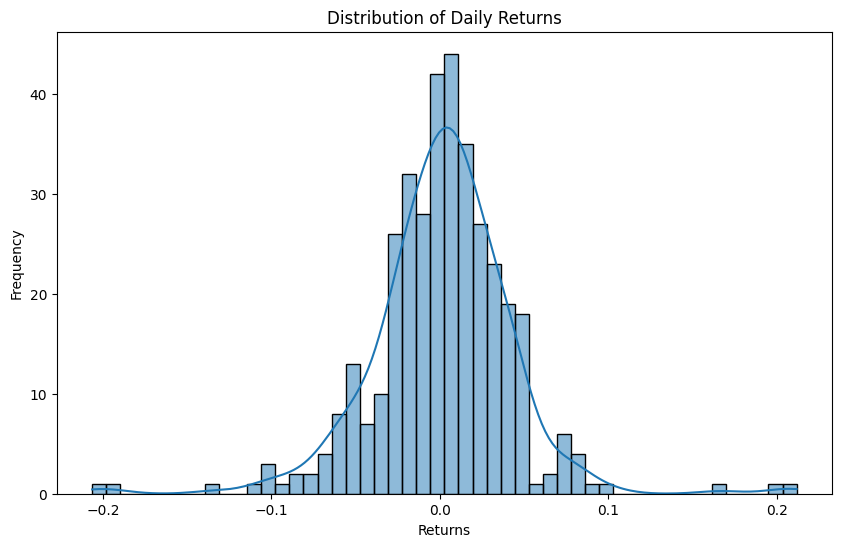

In [ ]:
# Calculate daily returns
data['Returns'] = data['Close'].pct_change()

# Plot histogram of returns
plt.figure(figsize=(10, 6))
sns.histplot(data['Returns'].dropna(), bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()


Stationarity Test
Check for stationarity in the stock price series using the Augmented Dickey-Fuller test.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(data['Close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.5975027485824593
p-value: 0.48484781317818965


Feature Engineering
Technical Indicators
Include RSI, MACD, Bollinger Bands, etc.

In [ ]:
# Calculate RSI
delta = data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# 3. Volatility Metrics (Bollinger Bands)
rolling_mean = data['Close'].rolling(window=20).mean()
rolling_std = data['Close'].rolling(window=20).std()
data['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
data['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)

Lag Variables
Incorporate lagged stock prices to capture autocorrelation.

In [ ]:
# Adding more lag variables
data['Lag_14'] = data['Close'].shift(14)
data['Lag_30'] = data['Close'].shift(30)


Sentiment Analysis
You can use NLP libraries to analyze sentiment from news or social media.

In [ ]:
from textblob import TextBlob

# Example sentiment analysis on a list of news headlines (assuming 'news_data' is a DataFrame with a 'headline' column)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Sample news headlines
news_data = pd.DataFrame({'headline': ["Apple's stock soars", "Concerns over Apple supply chain", "Apple launches new product"]})
news_data['Sentiment'] = news_data['headline'].apply(get_sentiment)

# Merge sentiment scores with stock data (this is just an example)
data['Sentiment'] = news_data['Sentiment'].mean()  # Assuming all news headlines are related to the same period


Dimensionality Reduction
You can use PCA to reduce features.

In [ ]:
# Ensure the 'features' DataFrame is defined properly
features = data[['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'SMA_30']].copy()  # Create a copy to avoid warnings

# Check for missing values in features DataFrame
print("Missing values before handling:\n", features.isnull().sum())

# Fill missing values using interpolation
features = features.interpolate(method='linear')

# Verify there are no NaN values left
print("Missing values after interpolation:\n", features.isnull().sum())

# Drop rows with any remaining missing values (if interpolation fails for some)
features = features.dropna()

# Verify there are no NaN values left
print("Missing values after dropping rows:\n", features.isnull().sum())

# Align the main data by dropping the same indices
data = data.loc[features.index].reset_index(drop=True)


Missing values before handling:
 Price            Ticker
RSI                        13
MACD                        0
Bollinger_Upper            19
Bollinger_Lower            19
SMA_30                      0
dtype: int64
Missing values after interpolation:
 Price            Ticker
RSI                        13
MACD                        0
Bollinger_Upper            19
Bollinger_Lower            19
SMA_30                      0
dtype: int64
Missing values after dropping rows:
 Price            Ticker
RSI                        0
MACD                       0
Bollinger_Upper            0
Bollinger_Lower            0
SMA_30                     0
dtype: int64


Apply PCA After Handling Missing Values
Once you’ve dealt with the missing values, you can proceed to apply PCA.

In [ ]:
from sklearn.decomposition import PCA

# Select features for PCA
features = data[['SMA_30', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 'Lag_1', 'Lag_7']]

# Ensure no missing values before PCA
print(features.isnull().sum())  # Should show zero missing values

# Apply PCA
pca = PCA(n_components=3)
pca_features = pca.fit_transform(features)

# Create a DataFrame with PCA features
pca_df = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2', 'PCA3'])
data1 = pd.concat([data.reset_index(drop=True), pca_df], axis=1)


Price    Ticker
SMA_30             0
SMA_50             0
SMA_200            0
RSI                0
MACD               0
Lag_1              0
Lag_7              0
dtype: int64


Prepare the Data
You’ll need to split your dataset into training and testing sets and create sequences for the LSTM model.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature names
feature_names = ['SMA_30', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 'Lag_1', 'Lag_7']

# Get feature importances from XGBoost
importance_scores = xgb_model.feature_importances_

# Create Table 2
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Score': importance_scores
}).sort_values(by='Importance Score', ascending=False)

# Display Table 2
print("\n Feature Importance from XGBoost\n")
print(feature_importance_df.to_string(index=False))



 Feature Importance from XGBoost

Feature  Importance Score
  Lag_1          0.974471
   MACD          0.011985
SMA_200          0.004501
    RSI          0.002812
  Lag_7          0.002382
 SMA_50          0.002194
 SMA_30          0.001656


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Prepare features and target variable
features = data[['SMA_30', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 'Lag_1', 'Lag_7']].values
target = data['Close'].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Reshape the data for LSTM (samples, time steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


Build the LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Input
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))  # Input layer
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


Train the LSTM Model

In [ ]:
# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3439
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0973
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0444 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0565 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0330 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0402 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0365 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0421 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0400 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0383 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0365 
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0324 
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0355 
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0366 
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━

Predict with the LSTM Model

In [ ]:
# Make predictions with LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Prepare Data for Random Forest
The Random Forest model will use the same features, but without reshaping them.

In [ ]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions with XGBoost
y_pred_xgb = xgb_model.predict(X_test)


Combine Predictions
Now you can create a hybrid model by averaging the predictions from both models.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Use aligned test values (y_test_ensemble from earlier stacking code)
rmse_lstm = np.sqrt(mean_squared_error(y_test_ensemble, lstm_test_preds))
mae_lstm = mean_absolute_error(y_test_ensemble, lstm_test_preds)
mape_lstm = mean_absolute_percentage_error(y_test_ensemble, lstm_test_preds)

rmse_xgb = np.sqrt(mean_squared_error(y_test_ensemble, xgb_test_preds))
mae_xgb = mean_absolute_error(y_test_ensemble, xgb_test_preds)
mape_xgb = mean_absolute_percentage_error(y_test_ensemble, xgb_test_preds)

rmse_hybrid = np.sqrt(mean_squared_error(y_test_ensemble, y_pred_hybrid))
mae_hybrid = mean_absolute_error(y_test_ensemble, y_pred_hybrid)
mape_hybrid = mean_absolute_percentage_error(y_test_ensemble, y_pred_hybrid)

# Result summary
results_df = pd.DataFrame({
    "Model": ["LSTM", "XGBoost", "LSTM + XGBoost (Hybrid)"],
    "RMSE": [rmse_lstm, rmse_xgb, rmse_hybrid],
    "MAE": [mae_lstm, mae_xgb, mae_hybrid],
    "MAPE (%)": [mape_lstm, mape_xgb, mape_hybrid]
})

from IPython.display import display
display(results_df)


,Model,RMSE,MAE,MAPE (%)
0,LSTM,0.277422,0.236776,29.383429
1,XGBoost,0.043693,0.034604,4.571328
2,LSTM + XGBoost (Hybrid),0.043743,0.034618,4.573435


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Stack predictions from LSTM and XGBoost
hybrid_train = np.column_stack((lstm_model.predict(X_train_lstm).flatten(), xgb_model.predict(X_train)))
hybrid_test = np.column_stack((y_pred_lstm.flatten(), y_pred_xgb))

# Use a meta-model (e.g., Linear Regression) to combine predictions
meta_model = LinearRegression()
meta_model.fit(hybrid_train, y_train)

# Make final hybrid model predictions
y_pred_hybrid = meta_model.predict(hybrid_test)

# Evaluate the hybrid model
mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)
r2_hybrid = r2_score(y_test, y_pred_hybrid)

print(f"Hybrid Model Mean Squared Error: {mse_hybrid}")
print(f"Hybrid Model R² Score: {r2_hybrid}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Hybrid Model Mean Squared Error: 0.00048423472332092426
Hybrid Model R² Score: 0.9868574002829422


Evaluate the Model
You can evaluate the model’s performance using metrics like Mean Absolute Error (MAE) or Mean Squared Error (MSE).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate performance metrics for each model
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

rmse_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
mape_hybrid = mean_absolute_percentage_error(y_test, y_pred_hybrid)

# Create a dataframe for the results
results_df = pd.DataFrame({
    "Model": ["LSTM", "XGBoost", "LSTM + XGBoost (Hybrid)"],
    "RMSE": [rmse_lstm, rmse_xgb, rmse_hybrid],
    "MAE": [mae_lstm, mae_xgb, mae_hybrid],
    "MAPE (%)": [mape_lstm, mape_xgb, mape_hybrid]
})

from IPython.display import display
display(results_df)


,Model,RMSE,MAE,MAPE (%)
0,LSTM,0.036001,0.027556,5.205607
1,XGBoost,0.021734,0.016106,40.971922
2,LSTM + XGBoost (Hybrid),0.022005,0.016292,2.988738


Plot Predictions: Visualize actual vs. predicted stock prices.

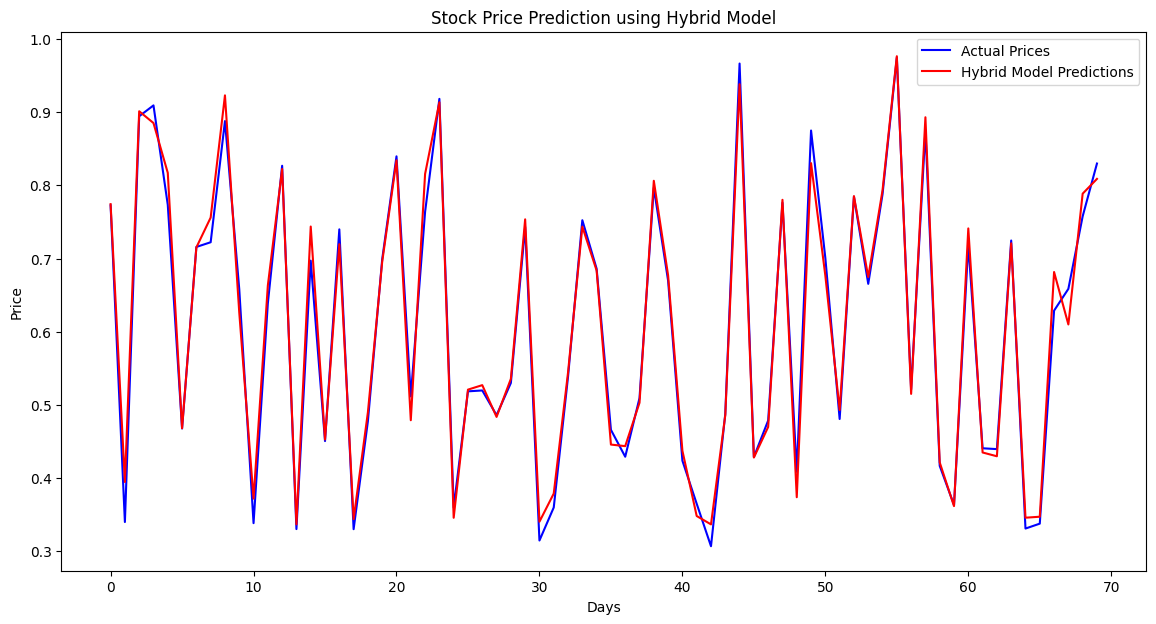

In [ ]:
# Optional: Plot Predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred_hybrid, label='Hybrid Model Predictions', color='red')
plt.title('Stock Price Prediction using Hybrid Model')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Function to compute RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi